# 03JUMP_predict - Using a Trained Micro𝕊plit Model

## Introduction - what does this notebook do?

In this notebook, we will use the trained model to unmix superimposed cellular structures in our JUMP dataset. We'll use the model we trained in the 02JUMP_train notebook.

This notebook will:
- Load the trained model
- Make predictions on test data
- Visualize and evaluate the results
- Compute quantitative metrics to assess model performance

In [21]:
# Import necessary libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import torch

# Import CAREamics libraries 
from careamics.lightning import VAEModule
from careamics.lvae_training.dataset import DataSplitType

# Import microsplit_reproducibility modules
from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.io import load_checkpoint, load_checkpoint_path
from microsplit_reproducibility.datasets import create_train_val_datasets
from microsplit_reproducibility.utils.paper_metrics import avg_range_inv_psnr, structural_similarity

# Import JUMP-specific modules
from microsplit_reproducibility.configs.data.JUMP import get_data_configs
from microsplit_reproducibility.configs.parameters.JUMP import get_microsplit_parameters
from microsplit_reproducibility.datasets.JUMP import get_train_val_data
from microsplit_reproducibility.notebook_utils.JUMP import (
    load_pretrained_model,
    get_unnormalized_predictions,
    get_target,
    get_input,
    full_frame_evaluation,
    show_sampling,
    pick_random_patches_with_content
)

In [22]:
class Channels:
    DNA = "DNA"
    Mito = "Mito"
    RNA = "RNA"
    ER = "ER"
    AGP = "AGP"

TARGET_CHANNEL_LIST = [Channels.RNA, Channels.ER, Channels.AGP]

# Load directory where dataset is stored
dataset_dir = "../experiments/3_channels/rna_er_agp"
print(f"Selected channels: {TARGET_CHANNEL_LIST}")

Selected channels: ['RNA', 'ER', 'AGP']


In [23]:
# Get data configurations
train_data_config, val_data_config, test_data_config = get_data_configs(
    channel_idx_list=TARGET_CHANNEL_LIST,
)

# Set up MicroSplit parameters
experiment_params = get_microsplit_parameters(
    nm_path="../noise_models",  
    channel_idx_list=TARGET_CHANNEL_LIST,
)

## Load the Trained Model

In [24]:
# Load datasets
train_dset, val_dset, test_dset, data_stats = create_train_val_datasets(
    datapath=dataset_dir,
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=test_data_config,
    load_data_func=get_train_val_data,
)


Padding is not used with this alignement style

Padding is not used with this alignement style

Padding is not used with this alignement style


## Choose whether to evaluate on validation or test data

In [25]:
evaluate_on_validation_data = False 
if evaluate_on_validation_data:
    print('Will use validation data', end='')
    dset = val_dset
else:
    print('Will use test data', end='')
    dset = test_dset
print(f' (containing a total of {dset.get_num_frames()} frames).')

Will use test data (containing a total of 2 frames).


## Load the checkpoint

In [26]:
# List all available checkpoints
def list_available_model_checkpoints():
    """List all model checkpoints available in the checkpoints and pretrained_checkpoints folders"""
    from pathlib import Path
    
    # Regular checkpoints (trained models)
    ckpt_folder = Path('../checkpoints/3_channels/rna_er_agp/best-epoch=9.ckpt')
    ckpt_files = list(ckpt_folder.glob("**/*.ckpt")) if ckpt_folder.exists() else []
    
    # Pretrained checkpoints
    pretrained_ckpt_folder = Path("./pretrained_checkpoints")
    pretrained_ckpt_files = list(pretrained_ckpt_folder.glob("**/*.ckpt")) if pretrained_ckpt_folder.exists() else []
    
    print("Available model checkpoints:")
    print("==========================")
    
    if ckpt_files:
        print("\nTrained model checkpoints:")
        for file in ckpt_files:
            print(f"- {file}")
    else:
        print("\nNo trained model checkpoints found.")
        
    if pretrained_ckpt_files:
        print("\nPretrained model checkpoints:")
        for file in pretrained_ckpt_files:
            print(f"- {file}")
    else:
        print("\nNo pretrained model checkpoints found.")
    
    return ckpt_files, pretrained_ckpt_files

ckpt_files, pretrained_ckpt_files = list_available_model_checkpoints()

# Select the most recent checkpoint by default, or specify a path
selected_ckpt = None
if ckpt_files:
    selected_ckpt = str(ckpt_files[0])
elif pretrained_ckpt_files:
    selected_ckpt = str(pretrained_ckpt_files[0])

# Option to manually specify a checkpoint path
user_selected_ckpt = '../checkpoints/3_channels/rna_er_agp/best-epoch=9.ckpt'
if user_selected_ckpt:
    selected_ckpt = user_selected_ckpt

if not selected_ckpt:
    raise ValueError("No model checkpoint found! Please train a model first or provide a pretrained checkpoint.")

print(f"Selected checkpoint: {selected_ckpt}")

Available model checkpoints:

No trained model checkpoints found.

No pretrained model checkpoints found.
Selected checkpoint: ../checkpoints/3_channels/rna_er_agp/best-epoch=9.ckpt


## Initialize the model 

In [27]:
experiment_params["data_stats"] = data_stats
model_config = get_model_config(**experiment_params)
loss_config = get_loss_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(**experiment_params)

# Create algorithm config
experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
)

# Create model and load checkpoint
model = VAEModule(algorithm_config=experiment_config)
load_pretrained_model(model, selected_ckpt)

[GaussianMixtureNoiseModel] min_sigma: 200.0
[GaussianMixtureNoiseModel] min_sigma: 200.0
[GaussianMixtureNoiseModel] min_sigma: 200.0
[MultiChannelNoiseModel] Nmodels count:3
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


/localscratch/mambaforge/envs/microsplit/lib/python3.9/site-packages/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


Loaded model from ../checkpoints/3_channels/rna_er_agp/best-epoch=9.ckpt


In [28]:
model = VAEModule(algorithm_config=experiment_config)

[GaussianMixtureNoiseModel] min_sigma: 200.0
[GaussianMixtureNoiseModel] min_sigma: 200.0
[GaussianMixtureNoiseModel] min_sigma: 200.0
[MultiChannelNoiseModel] Nmodels count:3
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


In [29]:
ckpt_dict = torch.load(selected_ckpt) #debugging

In [30]:
model.load_state_dict(ckpt_dict['state_dict'], strict=True) #debugging


<All keys matched successfully>

(3, 64, 64)


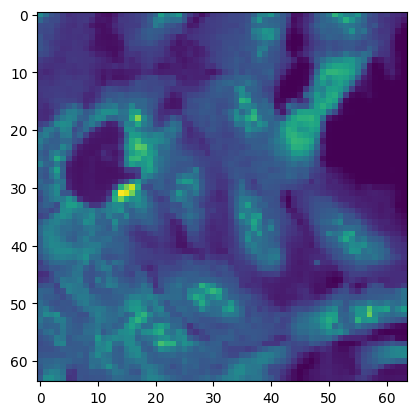

In [31]:
for i in train_dset:
    print(i[0].shape)
    plt.imshow(i[0][2])
    break

In [32]:
train_dset._data[0].shape #debugging

(1080, 1280, 4)

In [33]:
patch = train_dset._data[0][100:356, 100:356, :] #debugging

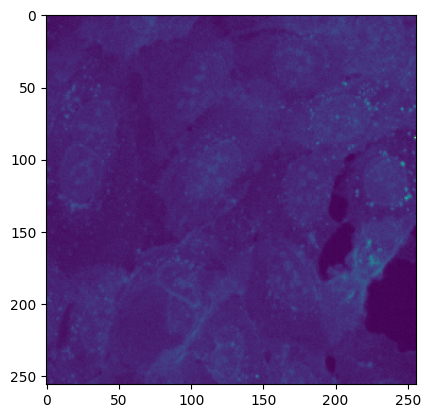

In [34]:
plt.imshow(patch[..., 2]) #debugging

## Now let's Make Predictions on Test Data

In [35]:
reduce_data = True
if reduce_data:
    print("Using REDUCED evaluation data for quick testing!")
    dset.reduce_data([0])
else:
    print('Using the full set of evaluation data!')
    print(f'(More specifically, I will use {dset.get_num_frames()} frames for evaluations.)')

# Generate predictions
stitched_predictions, norm_stitched_predictions, stitched_stds = get_unnormalized_predictions(
    model=model,
    dset=dset, 
    target_channel_list=TARGET_CHANNEL_LIST,
    mmse_count=100,
    num_workers=4,
    batch_size=32
)

# Get target and input data for evaluation
tar = get_target(dset)
inp = get_input(dset)

Using REDUCED evaluation data for quick testing!
[LCMultiChDloader] Data reduced. New data shape: (1, 1080, 1280, 4)


Predicting tiles: 100%|██████████| 41/41 [13:26<00:00, 19.68s/it]


## Let's visualize the predictions 

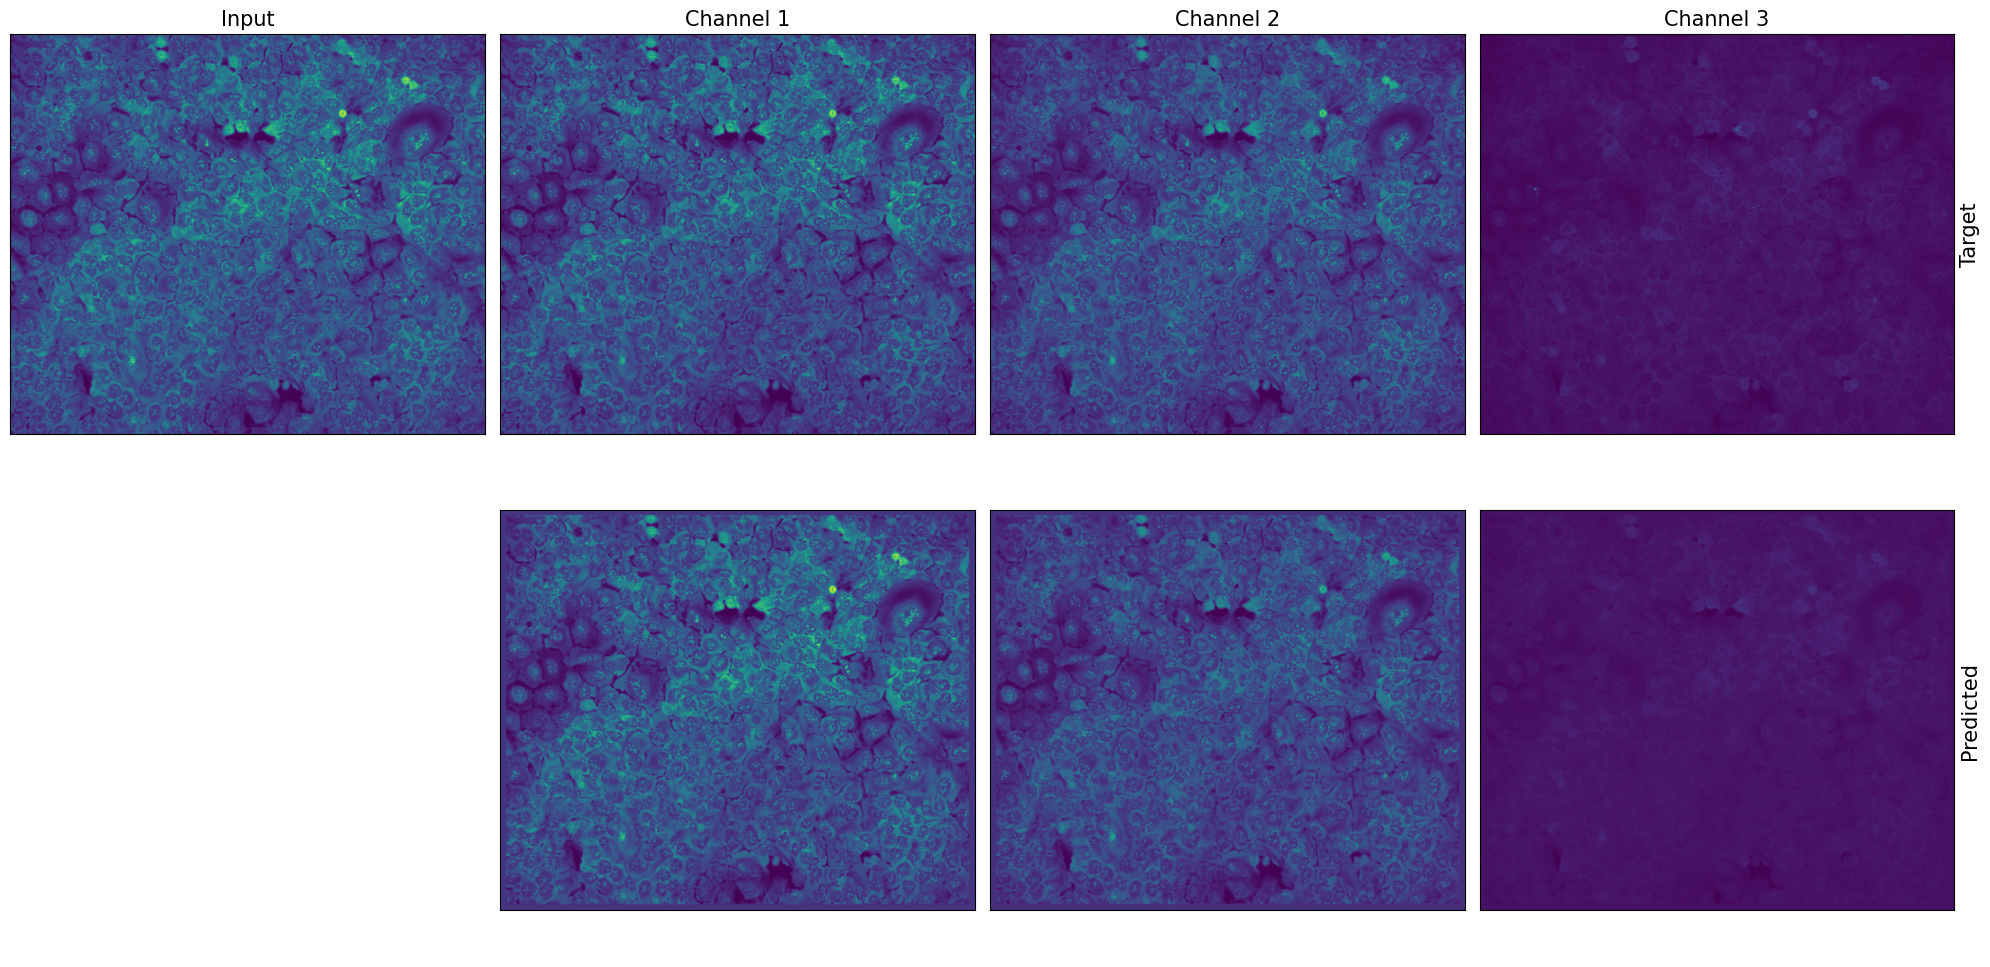

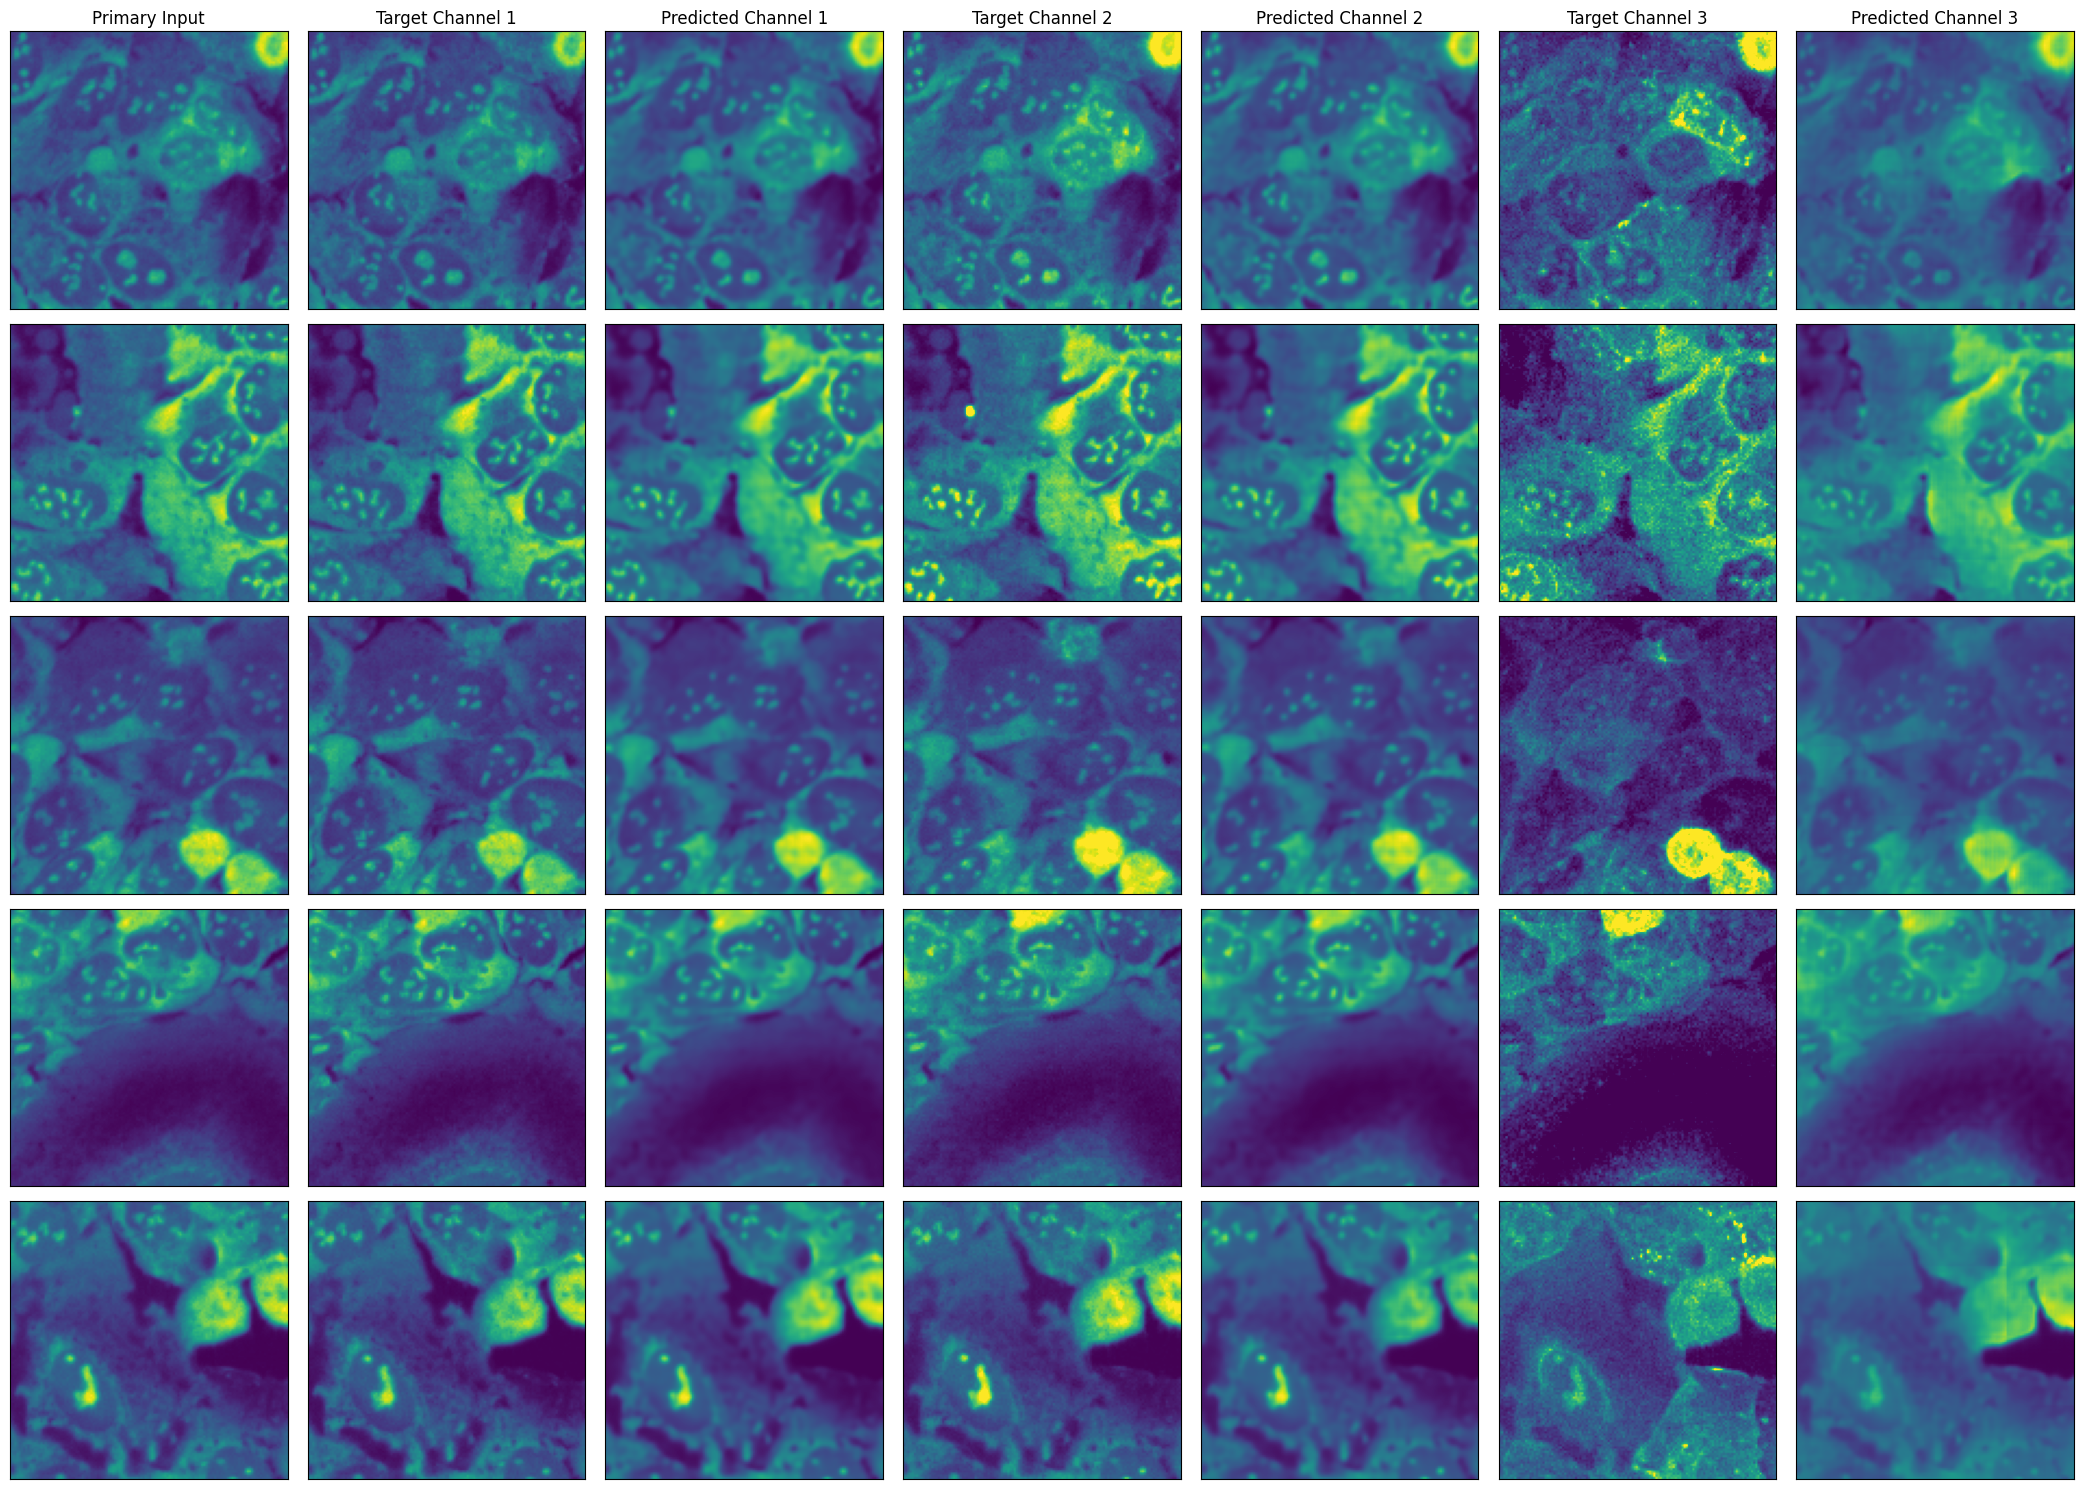

In [36]:
# Overview: full frame evaluation
frame_idx = 0
assert frame_idx < len(stitched_predictions), f"Frame index {frame_idx} out of bounds"
full_frame_evaluation(stitched_predictions[frame_idx], tar[frame_idx], inp[frame_idx])

# Detailed view of random regions with interesting content
img_sz = 128
rand_locations = pick_random_patches_with_content(tar, img_sz)

ncols = 2*len(TARGET_CHANNEL_LIST) + 1
nrows = min(len(rand_locations), 5)
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 3, nrows * 3))

for i, (h_start, w_start) in enumerate(rand_locations[:nrows]):
    ax[i,0].imshow(inp[0,h_start:h_start+img_sz, w_start:w_start+img_sz])
    for j in range(ncols//2):
        vmin = stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j].min()
        vmax = stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j].max()
        ax[i,2*j+1].imshow(tar[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j], vmin=vmin, vmax=vmax)
        ax[i,2*j+2].imshow(stitched_predictions[0,h_start:h_start+img_sz, w_start:w_start+img_sz,j], vmin=vmin, vmax=vmax)

ax[0,0].set_title('Primary Input')
for i in range(len(TARGET_CHANNEL_LIST)):
    ax[0,2*i+1].set_title(f'Target Channel {i+1}')
    ax[0,2*i+2].set_title(f'Predicted Channel {i+1}')

# Reduce spacing between subplots
plt.subplots_adjust(wspace=0.03, hspace=0.03)

# Remove axis ticks
for a in ax.ravel():
    a.set_xticks([])
    a.set_yticks([])

plt.tight_layout()
plt.show()

## We can inspect each region

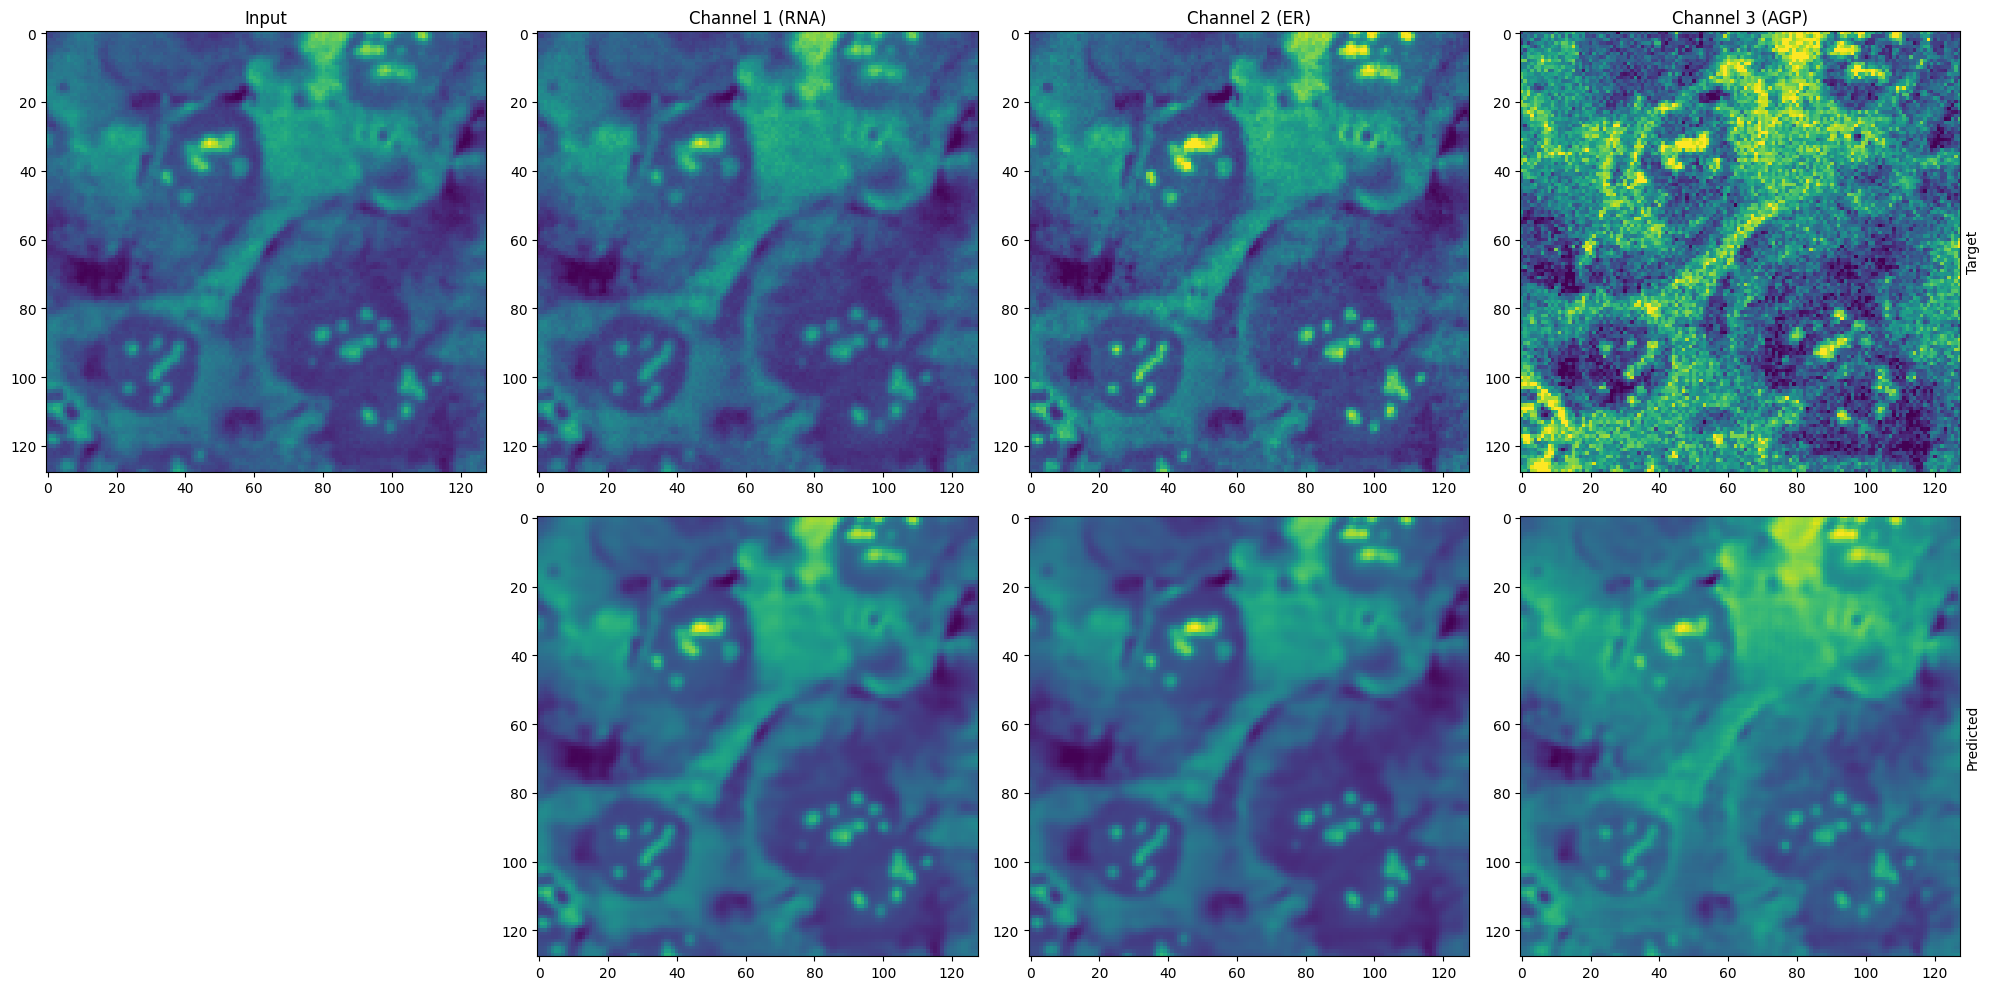

In [37]:
# Set coordinates for a specific region
y_start = 600
x_start = 600
crop_size = 128

ncols = len(TARGET_CHANNEL_LIST) + 1
nrows = 2
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols * 5, nrows * 5))

# Input image
ax[0,0].imshow(inp[0,y_start:y_start+crop_size, x_start:x_start+crop_size])
ax[1,0].axis('off')
ax[0,0].set_title("Input")

# Display each channel
for i in range(len(TARGET_CHANNEL_LIST)):
    vmin = stitched_predictions[0,y_start:y_start+crop_size, x_start:x_start+crop_size,i].min()
    vmax = stitched_predictions[0,y_start:y_start+crop_size, x_start:x_start+crop_size,i].max()
    
    # Target
    ax[0,i+1].imshow(tar[0,y_start:y_start+crop_size, x_start:x_start+crop_size,i], vmin=vmin, vmax=vmax)
    ax[0,i+1].set_title(f"Channel {i+1} ({TARGET_CHANNEL_LIST[i]})")
    
    # Prediction
    ax[1,i+1].imshow(stitched_predictions[0,y_start:y_start+crop_size, x_start:x_start+crop_size,i], vmin=vmin, vmax=vmax)
    
    # Add labels to the last channel
    if i == len(TARGET_CHANNEL_LIST)-1:
        ax[0,i+1].yaxis.set_label_position("right")
        ax[0,i+1].set_ylabel("Target")
        ax[1,i+1].yaxis.set_label_position("right")
        ax[1,i+1].set_ylabel("Predicted")

plt.tight_layout()
plt.show()

## Posterior Sampling and Uncertainty Visualization

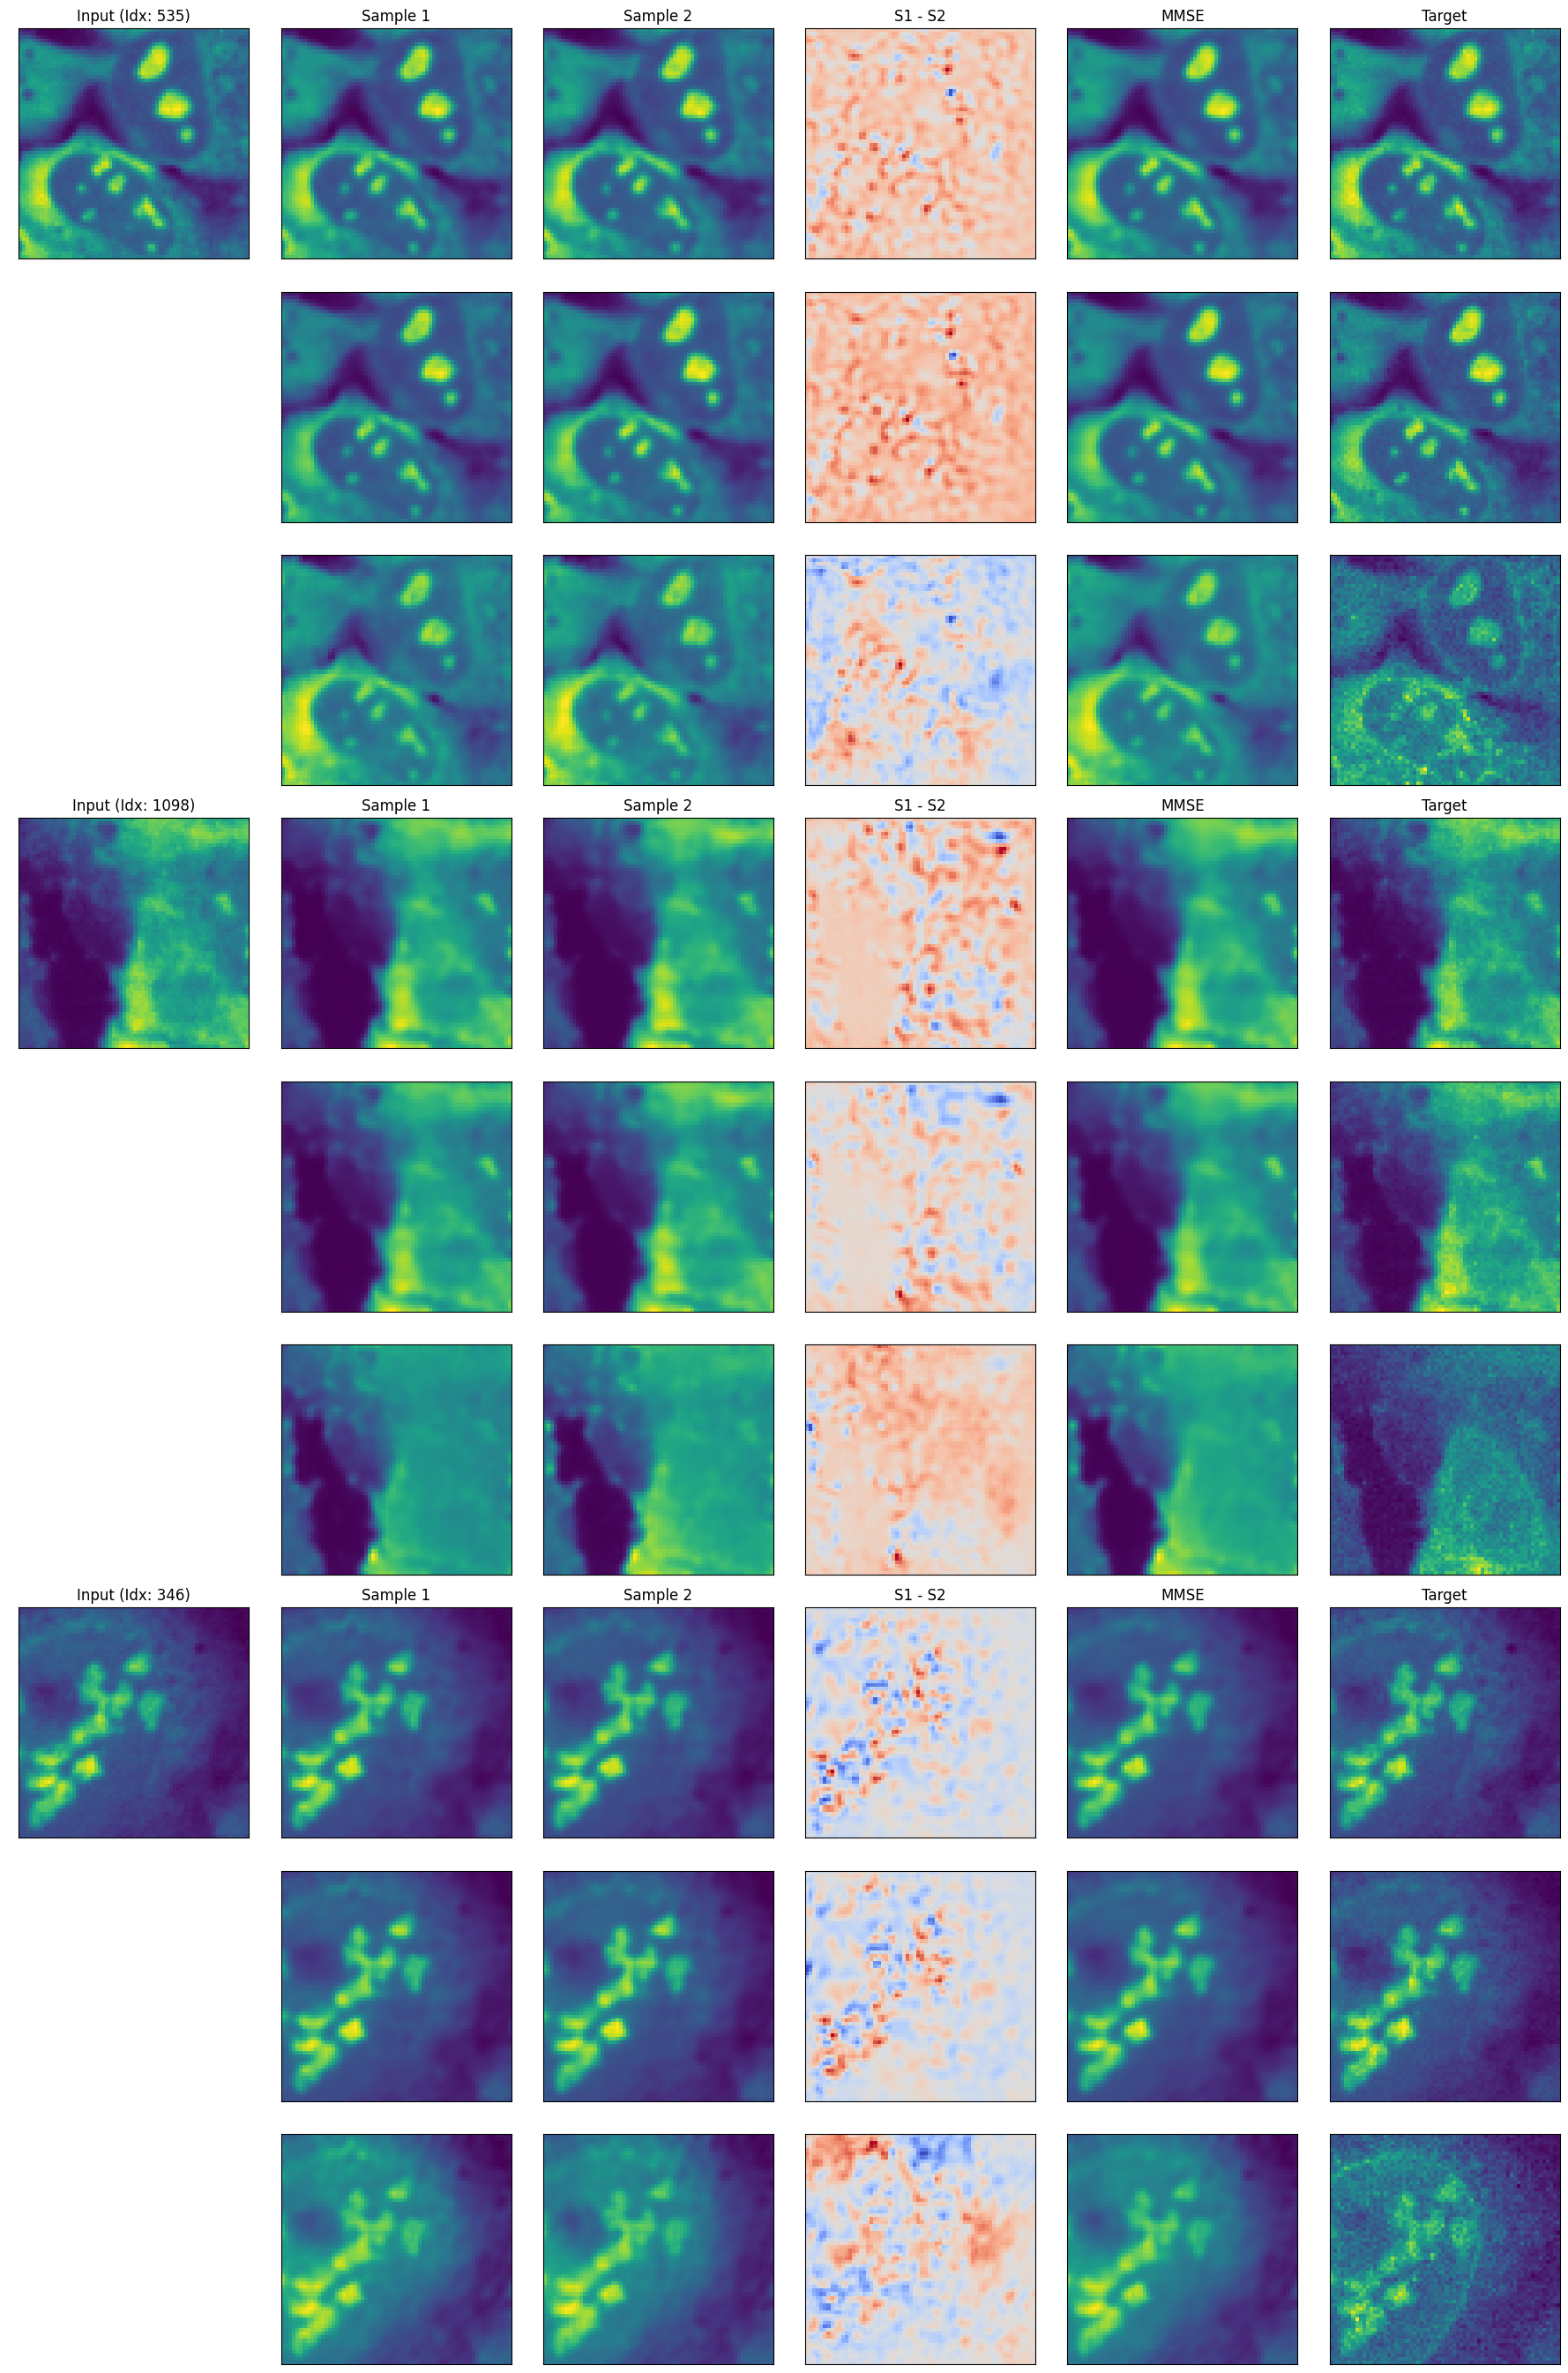

In [38]:
# Show posterior sampling
imgsz = 3
ncols = 6
num_channels = len(TARGET_CHANNEL_LIST)
num_examples = 3

# Create figure with enough rows for all channels across multiple examples
fig, ax = plt.subplots(figsize=(imgsz*ncols, imgsz*num_channels*num_examples), 
                      ncols=ncols, nrows=num_channels*num_examples)

# Show 3 examples, with each example having num_channels rows
for i in range(num_examples):
    row_indices = slice(i*num_channels, (i+1)*num_channels)
    show_sampling(dset, model, ax=ax[row_indices])

plt.tight_layout()
plt.show()

## Quantitative Evaluation

In [39]:
# Create output directory
channel_names = "_".join(ch for ch in TARGET_CHANNEL_LIST)
save_dir = f"3channels_predictions_{channel_names}"
os.makedirs(save_dir, exist_ok=True)
import pandas as pd

# Calculate metrics
psnr_results = []
ssim_results = []
for ch_idx in range(tar.shape[-1]):
    # Get PSNR for this channel
    psnr_val = avg_range_inv_psnr(
        [tar[i,...,ch_idx] for i in range(tar.shape[0])], 
        [stitched_predictions[i,...,ch_idx] for i in range(stitched_predictions.shape[0])]
    )
    psnr_results.append(psnr_val)
    
    # Get SSIM for this channel
    ssim_vals = []
    for i in range(tar.shape[0]):
        ssim_vals.append(structural_similarity(
            tar[i,...,ch_idx], 
            stitched_predictions[i,...,ch_idx],
            data_range=tar[i,...,ch_idx].max() - tar[i,...,ch_idx].min()
        ))
    ssim_results.append((np.mean(ssim_vals), np.std(ssim_vals)/np.sqrt(len(ssim_vals))))

# Print results
print("\nQuantitative Evaluation:")
print("=======================")
for i, channel in enumerate(TARGET_CHANNEL_LIST):
    print(f"Channel {i+1} ({channel}):")
    print(f"  PSNR: {psnr_results[i][0]:.2f} ± {psnr_results[i][1]:.3f}")
    print(f"  SSIM: {ssim_results[i][0]:.4f} ± {ssim_results[i][1]:.4f}")

# Save results to CSV
metrics_data = []
for i, channel in enumerate(TARGET_CHANNEL_LIST):
    metrics_data.append({
        'Channel': channel,
        'PSNR_Mean': psnr_results[i][0],
        'PSNR_Std': psnr_results[i][1],
        'SSIM_Mean': ssim_results[i][0],
        'SSIM_Std': ssim_results[i][1]
    })
metrics_df = pd.DataFrame(metrics_data)
metrics_csv_path = os.path.join(save_dir, "quantitative_metrics.csv")
metrics_df.to_csv(metrics_csv_path, index=False)
print(f"\nQuantitative metrics saved to: {metrics_csv_path}")




Quantitative Evaluation:
Channel 1 (RNA):
  PSNR: 30.08 ± 0.000
  SSIM: 0.9203 ± 0.0000
Channel 2 (ER):
  PSNR: 31.86 ± 0.000
  SSIM: 0.9016 ± 0.0000
Channel 3 (AGP):
  PSNR: 37.67 ± 0.000
  SSIM: 0.9273 ± 0.0000

Quantitative metrics saved to: 3channels_predictions_RNA_ER_AGP/quantitative_metrics.csv


In [40]:
# Save predictions
for i in range(len(stitched_predictions)):
    for j, channel in enumerate(TARGET_CHANNEL_LIST):
        # Save prediction
        pred_filename = f"pred_frame{i}_{channel}.tif"
        tifffile.imwrite(
            os.path.join(save_dir, pred_filename), 
            stitched_predictions[i, ..., j].astype(np.float32)
        )
        
        # Save target for reference
        target_filename = f"target_frame{i}_{channel}.tif"
        tifffile.imwrite(
            os.path.join(save_dir, target_filename), 
            tar[i, ..., j].astype(np.float32)
        )
        
        # Save input image for reference
        input_filename = f"input_frame{i}_combined.tif"
        tifffile.imwrite(
            os.path.join(save_dir, input_filename), 
            inp[i].astype(np.float32)
        )

print(f"\nAll predictions and metrics saved to directory: {save_dir}")
print("\nPrediction process complete!")


All predictions and metrics saved to directory: 3channels_predictions_RNA_ER_AGP

Prediction process complete!
